In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
MarRef = pd.read_csv('../MarRef_DBs/MarRef_v5.txt', sep='\t', index_col=44)
mmetsp_taxonomy = pd.read_csv('/vortexfs1/omics/alexander/data/mmetsp/taxonomy_v2.txt', sep='\t',
                              encoding = "ISO-8859-1", index_col='Source_ID')

In [31]:
def MMETSP_groupby(df, level='Division', normalized=True):
    division_MMETSP = df.merge(mmetsp_taxonomy[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = mmetsp_taxonomy.groupby(level)['Notes'].count()
    if normalized:
        division_MMETSP = division_MMETSP.T/total_per_group
        division_MMETSP = division_MMETSP.T
    return(division_MMETSP, total_per_group)
def create_cluster_bar(grouped_MMETSP, total_per_group, size=[12,12],
                       cutoff=False, c=5, genome=False, dropzero=False):
    grouped_MMETSP=grouped_MMETSP.dropna()
    if cutoff: 
        ii=total_per_group>c
        grouped_MMETSP= grouped_MMETSP.loc[ii]
        total_per_group=total_per_group[ii]
    if dropzero:
        ss= grouped_MMETSP[grouped_MMETSP.sum(axis=1)>0].index
        print(ss)
        grouped_MMETSP = grouped_MMETSP.loc[ss]
        total_per_group=total_per_group[ss]
    cluster = sns.clustermap(grouped_MMETSP, cmap='binary', yticklabels=1)
    cluster.fig.set_size_inches(size)
    
    # make some space to the right in the figure
    cluster.gs.update(right=0.95)
    # divide existing axes
    divider = make_axes_locatable(cluster.ax_heatmap)
    divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
    # create new axes for bar plot 
    ax = divider.append_axes("right", size="20%", pad=1.7)
    # create empty space of same size as bar plot axes (don't use this space)
    nax = divider2.new_horizontal(size="20%", pad=1.7)
    target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
    ind= np.array([list(grouped_MMETSP.index.values).index(t) for t in target])
    # plot bar plot in ax
    ax.barh(np.arange(len(target)), total_per_group.values[ind], color='k')
    ax.set_yticklabels([])
    ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    if genome:
        ax.set_xlabel('Total Genomes')
    else:
        ax.set_xlabel('Total Transcriptomes')
    ax.xaxis.set_label_position('top') 
    cluster.cax.set_position([0.1, .8, .02, 0.2])
    cluster.cax.set_ylabel('Proportion Gene present')

    plt.show()
    return(cluster)

def bact_groupby(df, level='phylum', normalized=True):
    division_bact = df.merge(MarRef[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = MarRef.groupby(level)['alt_elev'].count()
    if normalized:
        division_bact = division_bact.T/total_per_group
        division_bact = division_bact.T
    return(division_bact, total_per_group)

# Bacteria

In [3]:
bact_synth = pd.read_csv('../predict_synthesis/predicted-bacterial-osmolyte-synthesis.tsv', sep ='\t', header=[0, 1], index_col=0)

In [4]:
SYNTH = bact_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1)
BD = bact_synth.xs('BREAKDOWN', level=1, drop_level=False, axis=1)
SYNTH.columns = SYNTH.columns.droplevel(1)
BD.columns = BD.columns.droplevel(1)


In [5]:
summedbact = pd.DataFrame(SYNTH.sum()/len(SYNTH))
bd = pd.DataFrame(BD.sum()/len(BD))
summedbact=summedbact.merge(bd, left_index=True, right_index=True)
summedbact.columns=['SYNTHESIS', 'BREAKDOWN']
summedbact.sort_values('SYNTHESIS', ascending=False)

,SYNTHESIS,BREAKDOWN
Glutamine,1.000000,0.998885
Glutamate,0.998885,1.000000
Glycerol,0.484950,0.770346
Proline,0.445931,1.000000
Sorbitol,0.437012,0.371237
Glycine betaine,0.352285,0.004459
Sucrose,0.351171,0.633222
Mannitol,0.247492,0.326644
Trehalose,0.212932,0.313266
Ectoine,0.143813,0.152731


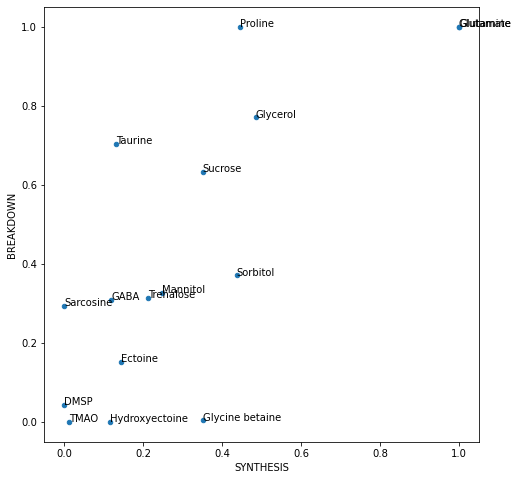

In [6]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)
ax.set_aspect('equal')
summedbact.plot(kind='scatter', x='SYNTHESIS', y='BREAKDOWN', ax = ax)
for i in summedbact.index:
    ax.text(summedbact.loc[i,'SYNTHESIS'], summedbact.loc[i,'BREAKDOWN'], i)

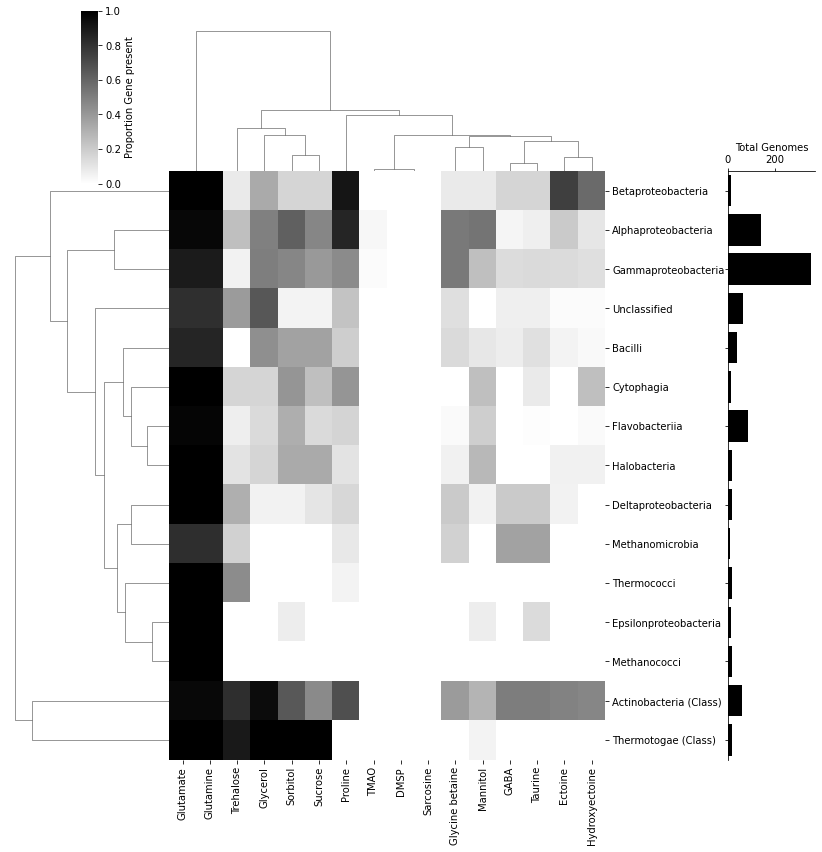

In [7]:
Sdivision_bact, Stotal_bac_group  = bact_groupby(SYNTH,  level='class', normalized=True)
create_cluster_bar(Sdivision_bact, Stotal_bac_group, genome=True, cutoff=True, c=10)

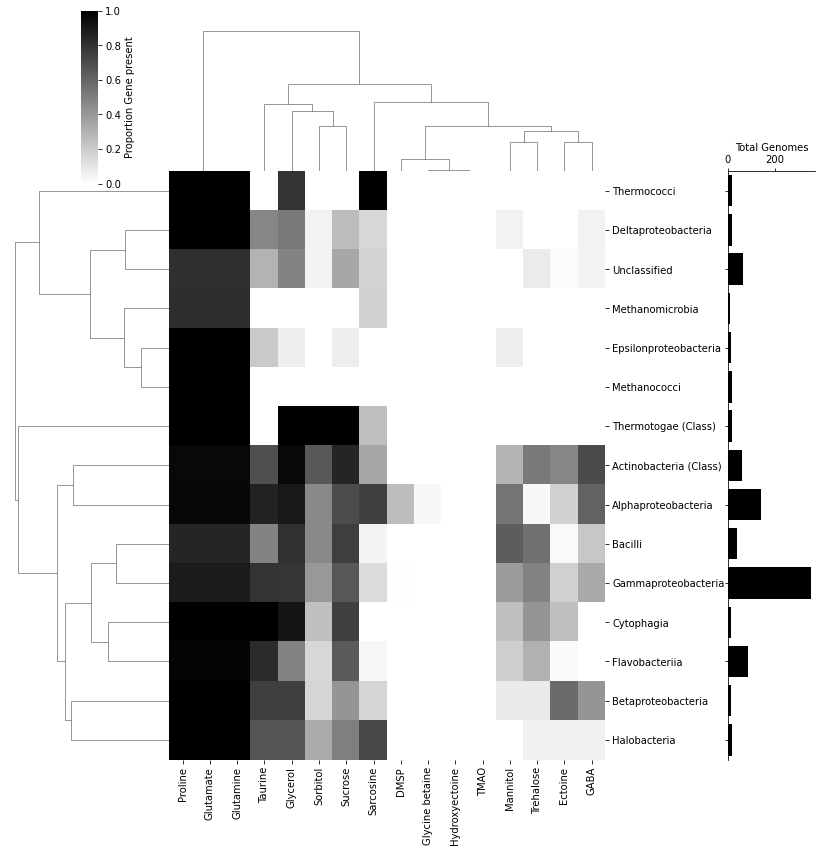

In [8]:
Bdivision_bact, Btotal_bac_group  = bact_groupby(BD,  level='class', normalized=True)
create_cluster_bar(Bdivision_bact, Btotal_bac_group, genome=True, cutoff=True, c=10)

In [23]:
euk_synth = pd.read_csv('../predict_synthesis/predicted-mmetsp-osmolyte-synthesis.tsv', sep ='\t', header=[0, 1], index_col=0)
euk_synth.index = euk_synth.index.str.strip('_clean')

In [24]:
ESYNTH = euk_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1)
EBD = euk_synth.xs('BREAKDOWN', level=1, drop_level=False, axis=1)
ESYNTH.columns = ESYNTH.columns.droplevel(1)
EBD.columns = EBD.columns.droplevel(1)



In [25]:
Esummed = pd.DataFrame(ESYNTH.sum()/len(ESYNTH))
Ebd = pd.DataFrame(EBD.sum()/len(EBD))
Esummed=Esummed.merge(Ebd, left_index=True, right_index=True)
Esummed.columns=['SYNTHESIS', 'BREAKDOWN']
Esummed.sort_values('SYNTHESIS', ascending=False)

,SYNTHESIS,BREAKDOWN
Glutamate,0.995399,0.995399
Glutamine,0.993865,0.993865
Glycerol,0.811350,0.858896
Sorbitol,0.765337,0.751534
Sucrose,0.753067,0.644172
Proline,0.535276,0.983129
Trehalose,0.246933,0.361963
Taurine,0.225460,0.475460
GABA,0.214724,0.286810
Mannitol,0.124233,0.056748


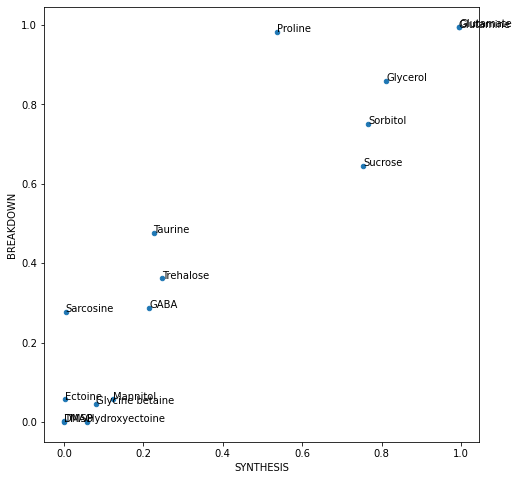

In [26]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)
ax.set_aspect('equal')
Esummed.plot(kind='scatter', x='SYNTHESIS', y='BREAKDOWN', ax = ax)
for i in Esummed.index:
    ax.text(Esummed.loc[i,'SYNTHESIS'], Esummed.loc[i,'BREAKDOWN'], i)

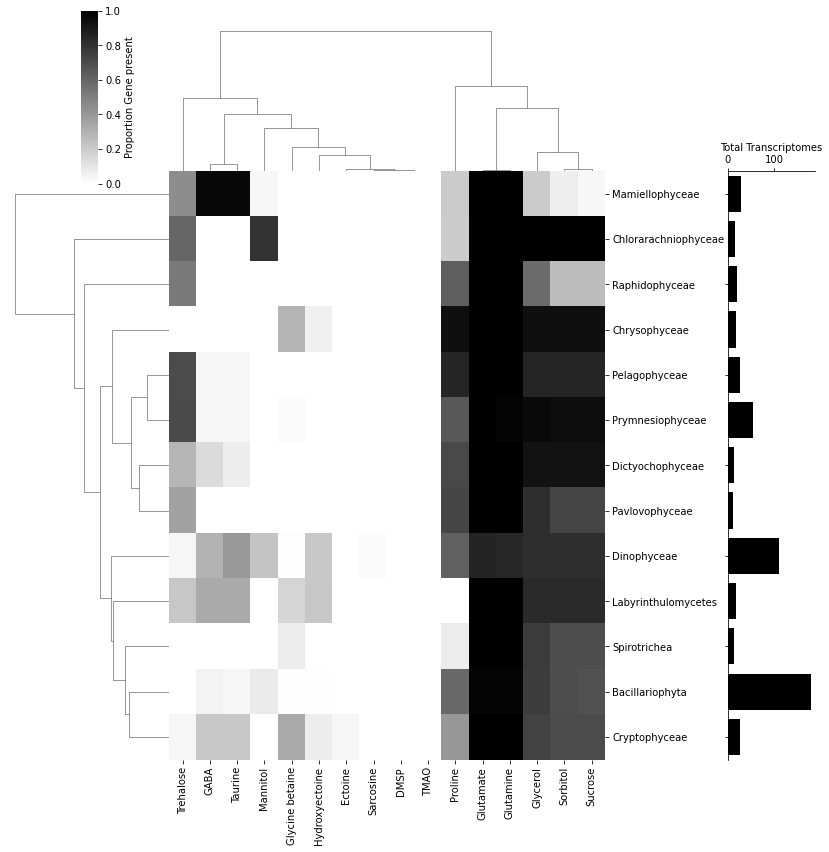

In [33]:
SEdivision, SEtotal_group  = MMETSP_groupby(ESYNTH,  level='Class', normalized=True)
create_cluster_bar(SEdivision, SEtotal_group, genome=False, cutoff=True, c=10)

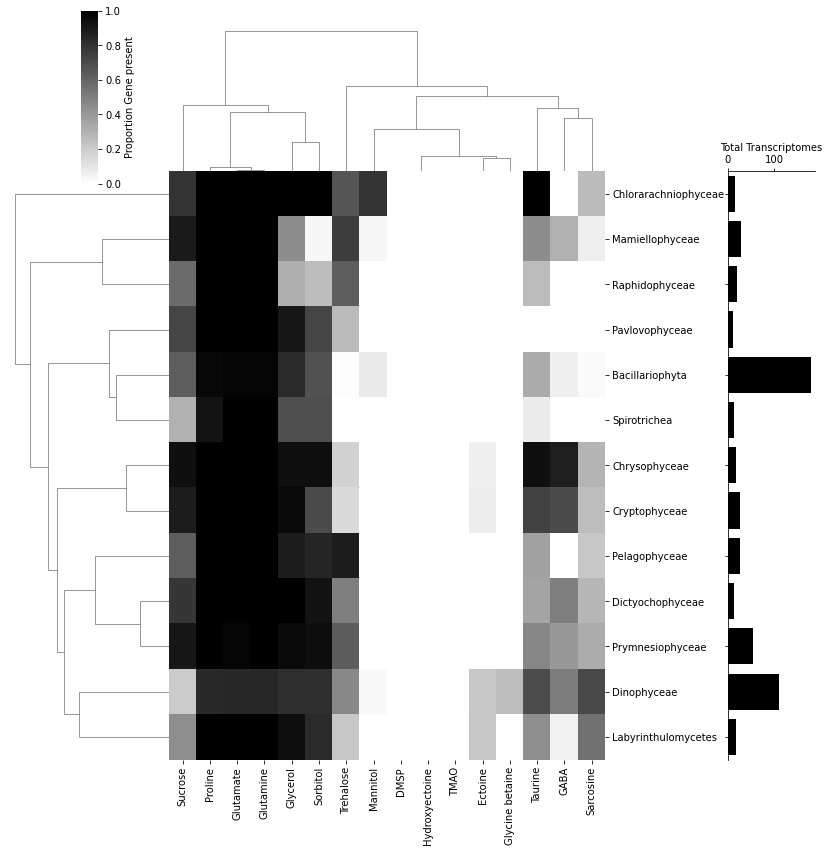

In [34]:
BEdivision, BEtotal_group  = MMETSP_groupby(EBD,  level='Class', normalized=True)
create_cluster_bar(BEdivision, BEtotal_group, genome=False, cutoff=True, c=10)